In [1]:
import pandas as pd

nifty200_df = pd.read_csv('nifty200.csv')
tickers = [ f'NSE:{n}-EQ' for n in nifty200_df.Symbol.tolist()]

In [2]:
from fyers_helper import prepare_data, load_stock_data
import datetime as dt

data_path = "/workspaces/codespaces-jupyter/data"

end_date = dt.datetime.now()
start_date = dt.datetime(2015, 1, 1)

file_paths = prepare_data(tickers, "1D", start_date=start_date, end_date=end_date, path=data_path, overwrite=False)
loaded_data = load_stock_data(file_paths, data_path, "1D")

Loading 1Dmin data: 100%|██████████| 200/200 [00:03<00:00, 62.21it/s]


In [3]:
df = pd.concat(loaded_data, names=["Stock", "Date"]).reset_index()
df = df[df.Date <= '2025-08-11 05:30:00']

In [4]:
import talib as ta

price_band = 0.03

df.Date = pd.to_datetime(df.Date)

# Calculate RSI per stock
df['SMA5'] = df.groupby('Stock')['Close'].transform(lambda x: ta.SMA(x, timeperiod=5))
df['SMA20'] = df.groupby('Stock')['Close'].transform(lambda x: ta.SMA(x, timeperiod=20))
df['SMA50'] = df.groupby('Stock')['Close'].transform(lambda x: ta.SMA(x, timeperiod=50))
df['SMA100'] = df.groupby('Stock')['Close'].transform(lambda x: ta.SMA(x, timeperiod=100))
df['SMA200'] = df.groupby('Stock')['Close'].transform(lambda x: ta.SMA(x, timeperiod=200))

df['VOL_SMA20'] = df.groupby('Stock')['Volume'].transform(lambda x: ta.SMA(x, timeperiod=20))

df['upper_threahold'] = df.Close * (1 + price_band)
df['lower_threahold'] = df.Close * (1 - price_band)

df['Entry_Price'] = df.groupby('Stock')['Close'].shift(-1)
df['Entry_Time'] = df.groupby('Stock')['Date'].shift(-1)
df['NxtHigh'] = df.groupby('Stock')['High'].shift(-1)

# df = df[df.Date >= '2024-01-01 05:30:00']

In [5]:
signals = (
    df[
        (df.Close > df.SMA5) &
        (df.SMA5 > df.SMA20) &
        (df.SMA20 > df.SMA50) &
        (df.SMA50 > df.SMA100) &
        (df.SMA100 < df.SMA200) &
        (df.NxtHigh >= df.SMA200)
    ]
)
signals = signals.sort_values(['Date', 'VOL_SMA20'], ascending=[True, False]).reset_index(drop=True)#.groupby('Date').head(3).reset_index(drop=True)

In [6]:
signals.Date.unique().shape

(1923,)

# Backtest

In [15]:
from lib import Bank, PositionManager
from tqdm.notebook import tqdm
import pandas as pd

leverage = 1
initial_capital = 100000
max_positions = 10
tp_perc = 3.14
default_bucket_capital = 10000


def book_profit(pm: PositionManager, row):
    global active_positions, closed_positions, bank
    for positon in pm.get_active_positions():
        stock_data = row[row.Stock == positon.stock]
        if stock_data.empty:
            continue
        stock_data = stock_data.iloc[0]
        if stock_data.High >= positon.tp:
            pm.close_position(positon.stock, stock_data.Date, positon.tp)
            break
        elif stock_data.Low <= positon.sl:
            pm.close_position(positon.stock, stock_data.Date, positon.sl)
            break
    
    

def backtest(pm: PositionManager):
    global active_positions, closed_positions, bank, max_positions
    pb = tqdm(total=df.Date.nunique(), desc="Backtesting...")
    for idx, row in df.groupby('Date'):
        day_signals = signals[signals.Date == idx]
        for signal in day_signals.itertuples():
            if signal.Stock in pm.get_active_positions():
                print(f"Already in position for {signal.Stock}")
                continue
            if not pm.bank.has_capital():
                pm.bank.add_capital(default_bucket_capital)
            pm.new_position(signal.Stock, signal.Entry_Time, signal.upper_threahold)

        book_profit(pm, row)
        pb.update(1)
    pb.close()
                
if __name__ == "__main__":
    bank = Bank(initial_capital, max_positions)
    pm = PositionManager(bank, leverage=leverage, tp_perc=tp_perc, sl_perc=100)
    backtest(pm)

Backtesting...:   0%|          | 0/2630 [00:00<?, ?it/s]

In [16]:
from dataclasses import  asdict
trades = pd.DataFrame([asdict(p) for p in pm.closed_positions]).sort_values(['entry_time']).reset_index(drop=True)#.to_csv(f'{root_path}/closed_positions.csv', index=False)

In [17]:
import pandas as pd

# Ensure entry_time and exit_time are datetime
trades['entry_time'] = pd.to_datetime(trades['entry_time'])
trades['exit_time'] = pd.to_datetime(trades['exit_time'])

# Total trades
total_trades = len(trades)

# Win rate
win_trades = (trades['pnl'] > 0).sum()
win_rate = win_trades / total_trades * 100 if total_trades > 0 else 0

# Total profit
total_profit = trades['pnl'].sum() - trades['tax'].sum()

# Total tax
total_tax = trades['tax'].sum()

# CAGR calculation
start = trades['entry_time'].min()
end = trades['exit_time'].max()
years = (end - start).days / 365.25
initial = initial_capital  # initial_capital from your code
final = initial + total_profit
cagr = ((final / initial) ** (1 / years) - 1) * 100 if years > 0 else None

# Active positions
active_position_count = sum([len(p.trades) for p in pm.get_active_positions() if p is not None])

# Period
period = f"{start.strftime('%Y-%m-%d')} to {end.strftime('%Y-%m-%d')}"

# Max holding period
max_holding_period = (trades['exit_time'] - trades['entry_time']).max().days
avg_holding_period = (trades['exit_time'] - trades['entry_time']).mean().days

# Final capital
final_capital = initial + total_profit

# Tearsheets summary
tearsheet = pd.DataFrame({
    'Metric': [
        'Period',
        'Final capital',
        'Total Trades',
        'Active Position Count',
        'Max holding period (days)',
        'Avg holding period (days)',
        'Win Rate (%)',
        'Total Profit',
        'Total Tax',
        'CAGR (%)'
    ],
    'Value': [
        period,
        f"{final_capital:.2f}",
        f"{total_trades:,}",
        f"{active_position_count:,}",
        f"{max_holding_period:,}",
        f"{avg_holding_period:,}",
        f"{win_rate:.2f}",
        f"{total_profit:,.2f}",
        f"{total_tax:.2f}" if total_tax else "N/A",
        f"{cagr:.2f}" if cagr else "N/A"
    ]
})

tearsheet

,Metric,Value
0,Period,2015-10-27 to 2025-08-11
1,Final capital,322462.73
2,Total Trades,745
3,Active Position Count,109
4,Max holding period (days),"1,268"
5,Avg holding period (days),65
6,Win Rate (%),100.00
7,Total Profit,"222,462.73"
8,Total Tax,2893.22
9,CAGR (%),12.70


<Axes: title={'center': 'Cumulative PnL vs Exit Time'}, xlabel='exit_time'>

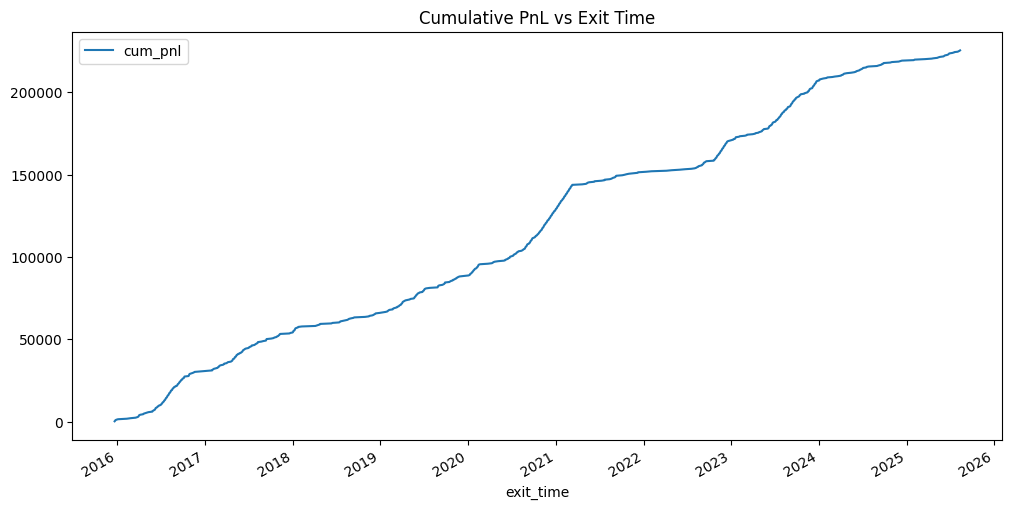

In [18]:
# ...existing code...
trades = trades.sort_values(['exit_time']).reset_index(drop=True)
trades['cum_pnl'] = trades['pnl'].cumsum()
trades.plot(x='exit_time', y='cum_pnl', title='Cumulative PnL vs Exit Time', figsize=(12, 6))

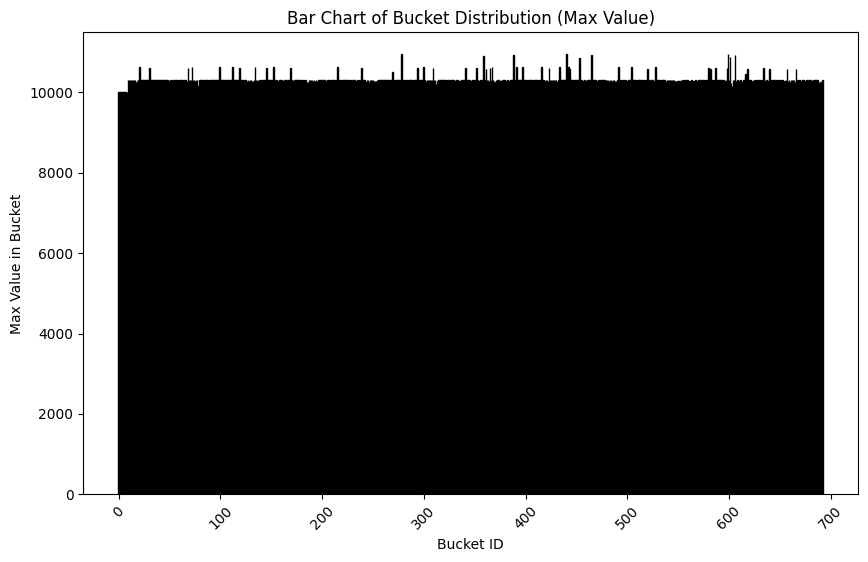

In [19]:
snapdf = pd.DataFrame(pd.DataFrame(bank.snapshot).max(), columns=['max'])
bucdf = pd.DataFrame(bank.bucket_usage_count, index=[0]).T
bucket_distribution = pd.concat([snapdf, bucdf], axis=1).rename(columns={0: 'usage_count'}).reset_index().rename(columns={'index': 'bucket_id'})

# ...existing code...
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(range(len(bucket_distribution['bucket_id'])), bucket_distribution['max'], edgecolor='black')
plt.title('Bar Chart of Bucket Distribution (Max Value)')
plt.xlabel('Bucket ID')
plt.ylabel('Max Value in Bucket')
plt.xticks(rotation=45)
plt.show()

In [21]:
signals.Date.unique().shape

(1923,)